<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/setup_tutorials/MOT_detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MOT Challenge Detections**

This notebook contains a detection workflow for the MOT Challenge. The purpose is to acquire detections on all MOT Challenge videos and use them for efficiently training a detection based tracker.



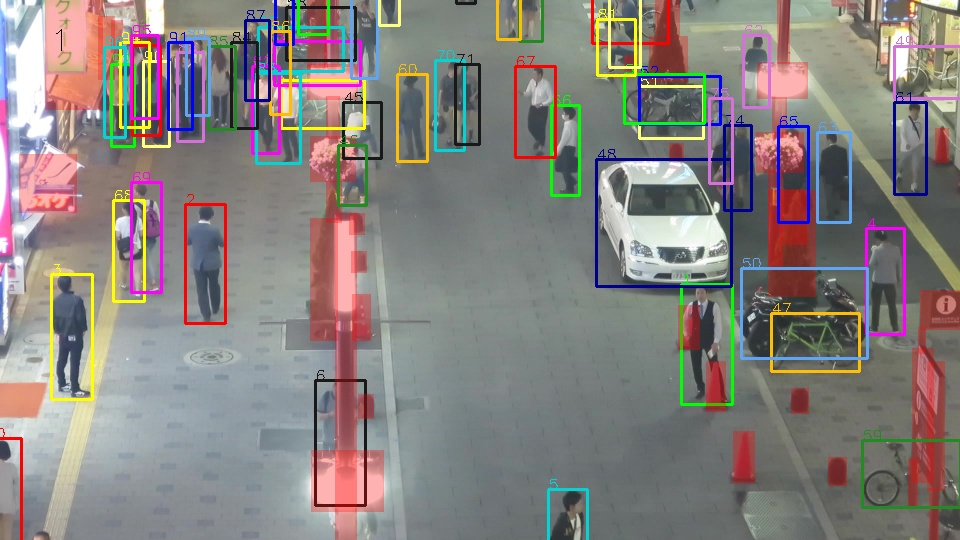

### Obtain MOT Challenge Data

In [ ]:
!wget https://motchallenge.net/data/MOT15.zip

In [5]:
!jar xf MOT15.zip

### Get YOLOv8

In [ ]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
!pip install -r requirements.txt
%cd ..
!pip install ultralytics

In [56]:
!pwd

/content/ultralytics


In [59]:
%cd ..

/content


### Base library import

In [7]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Get all folders

In [19]:
TRAIN_DIR = r"/content/MOT15/train"
TEST_DIR = r"/content/MOT15/test"

train_names = next(iter(os.walk(TRAIN_DIR)))[1]
test_names = next(iter(os.walk(TEST_DIR)))[1]

In [21]:
train_folders = []
for name in train_names:
    train_folders.append(os.path.join(TRAIN_DIR, name))

test_folders = []
for name in test_names:
    test_folders.append(os.path.join(TEST_DIR, name))

### Get MSCOCO Categories

In [32]:
import yaml

coco_fp = r"/content/ultralytics/ultralytics/datasets/coco.yaml"
with open(coco_fp, "r") as stream:
    try:
        coco_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# get classes dictionary
classes = coco_info['names']

### Get YOLOv8 Model

In [30]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

### Set up Detection pipeline

In [31]:
def get_detections(model, frame, conf=0.25):
    """ Obtains object detections from a single frame
        Inputs:
            model - YOLOv8 model object
            frame - RGB frame for detection
        Outputs:
            detections - array containing all detections and classes
                [[x1,y1,x2,y2,cls],...]
        NOTE: can modify this to obtain detections for batches of frames
        """
    # can also process multiple frames at once
    results = model(source=frame, stream=True, conf=conf, nms=True, 
                    iou=0.5, verbose=False)

    for result in results:
        xyxy = result.boxes.xyxy.cpu().numpy()
        cls = result.boxes.cls.cpu().numpy()
        conf_score = result.boxes.conf.cpu().numpy()

    return np.hstack((xyxy, np.c_[cls], np.c_[conf_score]))

In [64]:
def save_detections(image_paths, name):
    """ Obtains all detections and saves them as a .csv
        image_paths - abspaths to all video frames
        name - name of the current video
        """
    # get detections for all frames
    all_detections = []
    for fpath in image_paths:
        frame = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
        detections = get_detections(model, frame)
        all_detections.append(detections)

    # get frame size for current video
    frame_size = frame.shape[:2]

    # get detections in savable format
    save_detections = []
    for i in range(len(all_detections)):
        save_detections.append(np.hstack((np.ones((len(all_detections[i]), 1))*i, all_detections[i])))

    # place in DataFrame
    df = pd.DataFrame(np.vstack(save_detections))
    df.columns = ["frame", "x1", "y1", "x2", "y2", "cat", "conf"]

    # save to csv
    save_name = "{}_{}_{}.csv".format(name, frame_size[0], frame_size[1])
    df.to_csv(save_name)

In [ ]:
for folder_ in (train_folders + test_folders):
    name = os.path.basename(folder_)
    print(f"Getting Detections for: {name}")
    image_paths = sorted(glob(os.path.join(folder_, "**/*.jpg")))
    save_detections(image_paths, name)

print("All detections saved sucessfully")

Getting Detections for: ADL-Rundle-6
Getting Detections for: KITTI-17
Getting Detections for: Venice-2
